## Tutorial 2: Reducing a heat equation using balanced truncation

### Heat equation

We consider the following heat equation over $[0, 1]$ with two inputs
$u_1, u_2$ and three outputs $y_1, y_2, y_2$:

$$
\begin{align}
    \partial_t T(\xi, t) & = \partial_{\xi \xi} T(\xi, t) + u_1(t),
    & 0 < \xi < 1,\ t > 0, \\
    -\partial_\xi T(0, t) & = -T(0, t) + u_2(t),
    & t > 0, \\
    \partial_\xi T(1, t) & = -T(1, t),
    & t > 0, \\
    y_1(t) & = T(0, t),
    & t > 0, \\
    y_2(t) & = T(0.5, t),
    & t > 0, \\
    y_3(t) & = T(1, t),
    & t > 0.
\end{align}
$$

In the following, we will create a discretized model and reduce it using the
balanced truncation method to approximate the mapping from inputs
$u = (u_1, u_2)$ to outputs $y = (y_1, y_2, y_3)$.

### Discretized model

We need to construct a linear time-invariant (LTI) system

$$
\begin{align}
    E \dot{x}(t) & = A x(t) + B u(t), \\
    y(t) & = C x(t) + D u(t).
\end{align}
$$

In pyMOR, these models are captured by [LTIModels](./generated/pymor.models.html#pymor.models.iosys.LTIModel) from the
[pymor.models.iosys](./generated/pymor.models.html#module-pymor.models.iosys) module.

There are many ways of building an [LTIModel](./generated/pymor.models.html#pymor.models.iosys.LTIModel).
Here, we will use its [from_matrices](./generated/pymor.models.html#pymor.models.iosys.LTIModel.from_matrices) method,
which instantiates an [LTIModel](./generated/pymor.models.html#pymor.models.iosys.LTIModel) from NumPy or SciPy matrices.

First, we do the necessary imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sps
from pymor.basic import LTIModel, BTReductor

Next, we can assemble the matrices based on a centered finite difference
approximation:

In [2]:
k = 50
n = 2 * k + 1

A = sps.diags(
    [(n - 1) * [(n - 1)**2], n * [-2 * (n - 1)**2], (n - 1) * [(n - 1)**2]],
    [-1, 0, 1],
    format='lil',
)
A[0, 0] = A[-1, -1] = -2 * n * (n - 1)
A[0, 1] = A[-1, -2] = 2 * (n - 1)**2
A = A.tocsc()

B = np.zeros((n, 2))
B[:, 0] = 1
B[0, 1] = 2 * (n - 1)

C = np.zeros((3, n))
C[0, 0] = C[1, k] = C[2, -1] = 1

Then, we can create an [LTIModel](./generated/pymor.models.html#pymor.models.iosys.LTIModel):

In [3]:
fom = LTIModel.from_matrices(A, B, C)

We can get the internal representation of the [LTIModel](./generated/pymor.models.html#pymor.models.iosys.LTIModel) `fom`

In [4]:
fom

LTIModel(
    NumpyMatrixOperator(<101x101 sparse, 301 nnz>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<101x2 dense>, range_id='STATE'),
    NumpyMatrixOperator(<3x101 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    E=IdentityOperator(NumpyVectorSpace(101, id='STATE')))

From this, we see that the matrices were wrapped in [NumpyMatrixOperators](./generated/pymor.operators.html#pymor.operators.numpy.NumpyMatrixOperator),
while default values were chosen for $D$ and $E$ matrices
(respectively, zero and identity). The operators in an [LTIModel](./generated/pymor.models.html#pymor.models.iosys.LTIModel) can be
accessed directly, e.g., `fom.A`.

We can also see some basic information from `fom`’s string representation

In [5]:
print(fom)

LTIModel
    class: LTIModel
    number of equations: 101
    number of inputs:    2
    number of outputs:   3
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(101, id='STATE')


To visualize the behavior of the `fom`, we can draw its magnitude plot

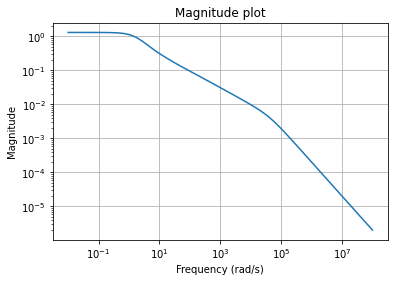

In [6]:
w = np.logspace(-2, 8, 50)
fom.mag_plot(w)
plt.grid()

Plotting the Hankel singular values shows us how well an LTI system can be
approximated by a reduced-order model

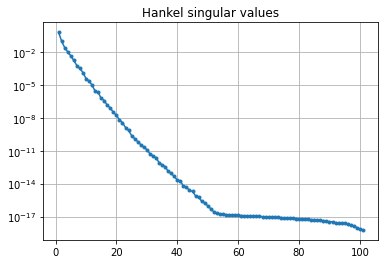

In [7]:
hsv = fom.hsv()
fig, ax = plt.subplots()
ax.semilogy(range(1, len(hsv) + 1), hsv, '.-')
ax.set_title('Hankel singular values')
ax.grid()

As expected for a heat equation, the Hankel singular values decay rapidly.

# Running balanced truncation

First, we need the reductor object

In [8]:
bt = BTReductor(fom)

Calling its [reduce](./generated/pymor.reductors.html#pymor.reductors.bt.GenericBTReductor.reduce) method runs the
balanced truncation algorithm. This reductor additionally has an `error_bounds`
method which can compute the a priori $\mathcal{H}_\infty$ error bounds
based on the Hankel singular values:

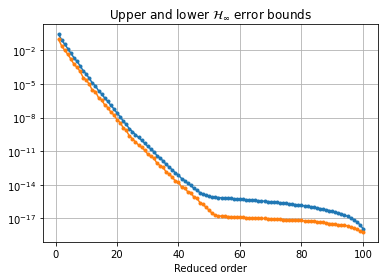

In [9]:
error_bounds = bt.error_bounds()
fig, ax = plt.subplots()
ax.semilogy(range(1, len(error_bounds) + 1), error_bounds, '.-')
ax.semilogy(range(1, len(hsv)), hsv[1:], '.-')
ax.set_xlabel('Reduced order')
ax.set_title(r'Upper and lower $\mathcal{H}_\infty$ error bounds')
ax.grid()

To get a reduced-order model of order 10, we call the `reduce` method with the
appropriate argument:

In [10]:
rom = bt.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Instead, or in addition, a tolerance for the $\mathcal{H}_\infty$ error
can be specified, as well as the projection algorithm (by default, the
balancing-free square root method is used).

We can compare the magnitude plots between the full-order and reduced-order
models

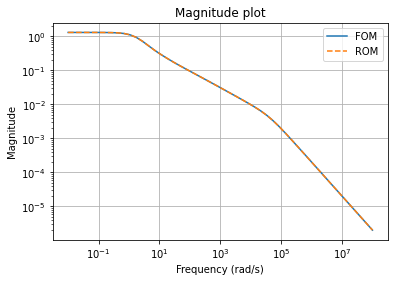

In [11]:
fig, ax = plt.subplots()
fom.mag_plot(w, ax=ax, label='FOM')
rom.mag_plot(w, ax=ax, linestyle='--', label='ROM')
ax.legend()
ax.grid()

and plot the magnitude plot of the error system

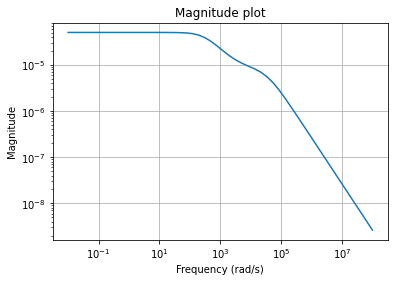

In [12]:
(fom - rom).mag_plot(w)
plt.grid()

We can compute the relative errors in $\mathcal{H}_\infty$ or
$\mathcal{H}_2$ (or Hankel) norm

In [13]:
print(f'Relative Hinf error: {(fom - rom).hinf_norm() / fom.hinf_norm():.3e}')
print(f'Relative H2 error:   {(fom - rom).h2_norm() / fom.h2_norm():.3e}')

Relative Hinf error: 3.702e-05
Relative H2 error:   6.399e-04


To compute the $\mathcal{H}_\infty$ norms, pyMOR uses the dense solver
from Slycot.